In [1]:
from pathlib import Path
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import sys
import csv

import matplotlib.pyplot as plt

DATA_FOLDER = Path('/data/NER')
DATASET = DATA_FOLDER / 'regex_dataset.tsv'
DATASET_TO_ANNOTATE = DATA_FOLDER / 'annotation_sentences.csv'

In [3]:
%time data = pd.read_csv(str(DATASET), delimiter='\t')

CPU times: user 25.6 s, sys: 1.21 s, total: 26.8 s
Wall time: 26.8 s


In [4]:
data[data.addr==0].shape

(8222831, 4)

In [6]:
sym = ' "=-.,!?():%'
rus = 'абвгдеёжзиклмнопрстуфхцчшщъыьэюя'
eng = 'abcdefghijklmnopqrstuvwxyz'
dig = '0123456789'

c2id = {c: i+1 for i, c in enumerate(sym+rus+eng+dig)}
id2c = {i: c for c, i in c2id.items()}

capitals = set(c.upper() for c in rus + eng)

CHAR_DIM = len(c2id) + 1

def char2tensor(line, length=256, char_dim=CHAR_DIM):
    tensor = torch.zeros(length, char_dim)
    for k, c in enumerate(line[:length]):
        i = c2id.get(c.lower(), None)
        if i is None:
            continue
        u = int(c in capitals)                
        tensor[k, 0] = u
        tensor[k, i] = 1
    return tensor

def tensor2char(tensor):
    chars_tensor = tensor[:, 1:]
    res = []
    for k in range(len(tensor)):
        u = int(tensor[k, 0])
        max_val, i = chars_tensor[k].max(dim=0)
        
        if max_val[0] == 0:
            break        
        c = id2c[i[0]+1]
#         print(k, c, i[0], u, sep='\t')
        res.append(c.upper() if u else c)
    return ''.join(res)


str_msg = 'Привет там!'
tensor_msg = char2tensor(str_msg)
assert str_msg == tensor2char(tensor_msg)

In [7]:
HIDDEN_DIM = 49

class RNN(nn.Module):
    def __init__(self, input_dim):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        
        self.rnn = nn.LSTM(self.input_dim, HIDDEN_DIM, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(HIDDEN_DIM*2, 1)
        self.logit = nn.Sigmoid()
        
    def forward(self, input):
        out, _ = self.rnn.forward(input)
        out, _ = out.max(1)
        out = self.linear.forward(out)
        out = self.logit(out)
        return out

In [8]:
def cyclic(dataset : list, batch_size):
    data_ = list(dataset)
    while True:
        random.shuffle(data_)
        for i in range(0, len(data_) // batch_size * batch_size, batch_size):
            yield data_[i:i+batch_size]

In [9]:
def pd_cyclic(dataset : pd.DataFrame, batch_size):   
    while True:
        data_ = dataset.sample(frac=1)
        for i in range(0, len(data_) // batch_size * batch_size, batch_size):
            yield data_.iloc[i:i+batch_size]

In [11]:
rnn = RNN(CHAR_DIM)
rnn.cuda()

pos = data[data.addr==1].sample(frac=1)
train_pos_gen = pd_cyclic(pos.iloc[:int(len(pos) * 0.9)], 11)
test_pos = pd_cyclic(pos.iloc[int(len(pos) * 0.9):], int(len(pos) * 0.1))

neg = data[data.addr==0].sample(frac=1)
train_neg_gen = pd_cyclic(neg.iloc[:int(len(neg) * 0.9)], 43)
test_neg = pd_cyclic(neg.iloc[int(len(neg) * 0.9):], int(len(pos) * 0.1) * 4)

train_losses = []
test_losses = []
obs_for_losses = []

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn.parameters())

In [15]:
%%time

print('#seen', 'train', 'test', sep='\t')

train_local_losses = []



obs_seen = 0
for pos, neg in zip(train_pos_gen, train_neg_gen):
    batch = pd.concat([pos, neg])
    batch_size = len(batch)
    
    obs_seen += batch_size
    rnn.zero_grad()
    
    y = Variable(torch.cuda.FloatTensor(batch.addr.values))
    x = Variable(torch.stack(batch.text.apply(char2tensor).values)).cuda()
    
    y_hat = rnn(x)   
    loss = criterion(y_hat, y)
    loss.backward()
    
    optimizer.step()
    
#     print(obs_seen, loss.data[0])
    train_local_losses.append(loss.data[0])
    
    if obs_seen % (1000) < batch_size:
        test_batch = pd.concat([next(test_pos), next(test_neg)])
        test_y = Variable(torch.cuda.FloatTensor(test_batch.addr.values))
        test_x = Variable(torch.stack(test_batch.text.apply(char2tensor).values)).cuda()
        test_y_hat = rnn(test_x)
        test_loss = criterion(test_y_hat, test_y).data[0]
        
        
        test_losses.append(test_loss)
        train_losses.append(np.mean(train_local_losses))
        obs_for_losses.append(obs_seen)
        
        print(obs_seen, np.mean(train_local_losses), test_loss, sep='\t')
        
        train_local_losses = []
        
    if obs_seen > 500_000:
        break

#seen	train	test


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([3160])) that is different to the input size (torch.Size([3160, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


1026	0.673955616198088	0.6183071732521057
2052	0.5569803432414406	0.5082144737243652
3024	0.5089773767524295	0.5021372437477112
4050	0.5056340317977103	0.49952831864356995
5022	0.5041575796074338	0.49815019965171814
6048	0.5035027014581781	0.49650225043296814
7020	0.4996466437975566	0.4925881028175354
8046	0.49222548227561147	0.47310855984687805
9018	0.4865379267268711	0.4645930826663971
10044	0.44878115152057846	0.478875070810318
11016	0.4470920612414678	0.40972498059272766
12042	0.39301610306689616	0.3739366829395294
13014	0.3797721283303367	0.4436514973640442
14040	0.4649029468235217	0.4625388979911804
15012	0.46502286361323464	0.4527524411678314
16038	0.43761068111971807	0.40243175625801086
17010	0.46072400444083744	0.45952242612838745
18036	0.45935994857235957	0.4549742043018341
19008	0.46448711388640934	0.445821613073349
20034	0.4445771841626418	0.4363016188144684
21006	0.43343941039509243	0.42515650391578674
22032	0.42358733321491043	0.4042651653289795
23004	0.3939271287785636	0

181008	0.13322207145392895	0.11014994978904724
182034	0.12569637655427582	0.12419919669628143
183006	0.12320105162345701	0.10859966278076172
184032	0.09739945966162179	0.11344289779663086
185004	0.10354248330824906	0.10858545452356339
186030	0.08994561865141518	0.11406911164522171
187002	0.0975086929069625	0.10540566593408585
188028	0.09592661183131368	0.10106983780860901
189000	0.11498447093698713	0.11017947643995285
190026	0.11418126601921885	0.10447373986244202
191052	0.11578798901877906	0.12489373236894608
192024	0.10900603379640314	0.11098781228065491
193050	0.11310713022555176	0.11771278083324432
194022	0.12364474963396788	0.1221243143081665
195048	0.1112293491238042	0.11182774603366852
196020	0.09445030345684952	0.10434230417013168
197046	0.11361884659058169	0.11352839320898056
198018	0.10975430988603169	0.10340678691864014
199044	0.10508871568660987	0.1032739207148552
200016	0.09615564801626736	0.10109677165746689
201042	0.09613133780658245	0.11271252483129501
202014	0.10093648

357048	0.08809224035786956	0.0886995941400528
358020	0.07758325928201278	0.09626851230859756
359046	0.09719492602897317	0.09322859346866608
360018	0.08820462226867676	0.09600081294775009
361044	0.10210477227443143	0.09923896938562393
362016	0.08801391431026989	0.0928260013461113
363042	0.07957534874348264	0.11093615740537643
364014	0.09652473705096377	0.10124858468770981
365040	0.09080697517645986	0.09352034330368042
366012	0.0669722350107299	0.08940953016281128
367038	0.06995855742379238	0.11289657652378082
368010	0.0854147235966391	0.09119193255901337
369036	0.09301978839855445	0.09308961033821106
370008	0.07442419122283657	0.08820395916700363
371034	0.07523087019983091	0.08495612442493439
372006	0.07705686707049608	0.08879171311855316
373032	0.062453963450695336	0.09701134264469147
374004	0.07788224342382616	0.08818690478801727
375030	0.07595525530019873	0.10149858891963959
376002	0.08265388312025203	0.08742709457874298
377028	0.059470150815813166	0.10321693122386932
378000	0.093640

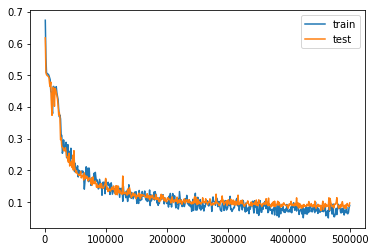

In [17]:
plt.plot(obs_for_losses, train_losses, label='train')
plt.plot(obs_for_losses, test_losses, label='test')
plt.legend()
plt.show()

In [19]:
%%time

with DATASET_TO_ANNOTATE.open('w') as f:
    cw = csv.writer(f)
    cw.writerow(['score', 'sentences', 'source', 'regex'])

    bs = 256
    for i in range(0, len(data), bs):
        try:
            d = data[i:i+bs]
            x = Variable(torch.stack(d.text.apply(char2tensor).values)).cuda()
            y_hat = rnn(x)
            scores = y_hat.data[:, 0].cpu().numpy()
            k = np.logical_or(scores > 0.9, d.addr.values)

            for s, (_, row) in zip(scores[k], d[k].iterrows()):
                cw.writerow([s, row.orig.strip(), row.source, row.addr])
        except Exception as ex:
            print(ex)
        if i % 10000 < bs:
            print(i)

0
10240
20224
30208
40192
50176
60160
70144
80128
90112
100096
110080
120064
130048
140032
150016
160000
170240
180224
190208
200192
210176
220160
230144
240128
250112
260096
270080
280064
290048
300032
310016
320000
330240
340224
350208
360192
370176
380160
390144
400128
410112
420096
430080
440064
450048
460032
470016
480000
490240
500224
510208
520192
530176
540160
550144
560128
570112
580096
590080
600064
610048
620032
630016
640000
650240
660224
670208
680192
690176
700160
710144
720128
730112
740096
750080
760064
770048
780032
790016
800000
810240
820224
830208
840192
850176
860160
870144
880128
890112
900096
910080
920064
930048
940032
950016
960000
970240
980224
990208
1000192
1010176
1020160
1030144
1040128
1050112
1060096
1070080
1080064
1090048
1100032
1110016
1120000
1130240
1140224
1150208
1160192
1170176
1180160
1190144
1200128
1210112
1220096
1230080
1240064
1250048
1260032
1270016
1280000
1290240
1300224
1310208
1320192
1330176
1340160
1350144
1360128
1370112
1380096
13